In [1]:

import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from numpy.linalg import LinAlgError
#import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
sns.set_style('whitegrid')



# After downloading data convert into log value

In [2]:
stock_df = yf.download(tickers='BTC-USD', start='2018-03-01', end='2023-03-03')

nvda_log = np.log(stock_df['Adj Close']).diff().dropna()

nvda_log


[*********************100%***********************]  1 of 1 completed


Date
2018-03-02 00:00:00+00:00    0.012288
2018-03-03 00:00:00+00:00    0.035732
2018-03-04 00:00:00+00:00    0.001991
2018-03-05 00:00:00+00:00    0.005259
2018-03-06 00:00:00+00:00   -0.071017
                               ...   
2023-02-26 00:00:00+00:00    0.016512
2023-02-27 00:00:00+00:00   -0.001629
2023-02-28 00:00:00+00:00   -0.016093
2023-03-01 00:00:00+00:00    0.021337
2023-03-02 00:00:00+00:00   -0.007261
Name: Adj Close, Length: 1827, dtype: float64

In [3]:
def plot_correlogram(x, lags=None, title=None):
    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    
    x.plot(ax=axes[0][0], title='Residuals')
    
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    probplot(x, plot=axes[0][1])
    
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    
    axes[1][0].set_xlabel('Lag')
    
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=14)
    
    sns.despine()
    
    fig.tight_layout()
    
    fig.subplots_adjust(top=.9)
    
    return

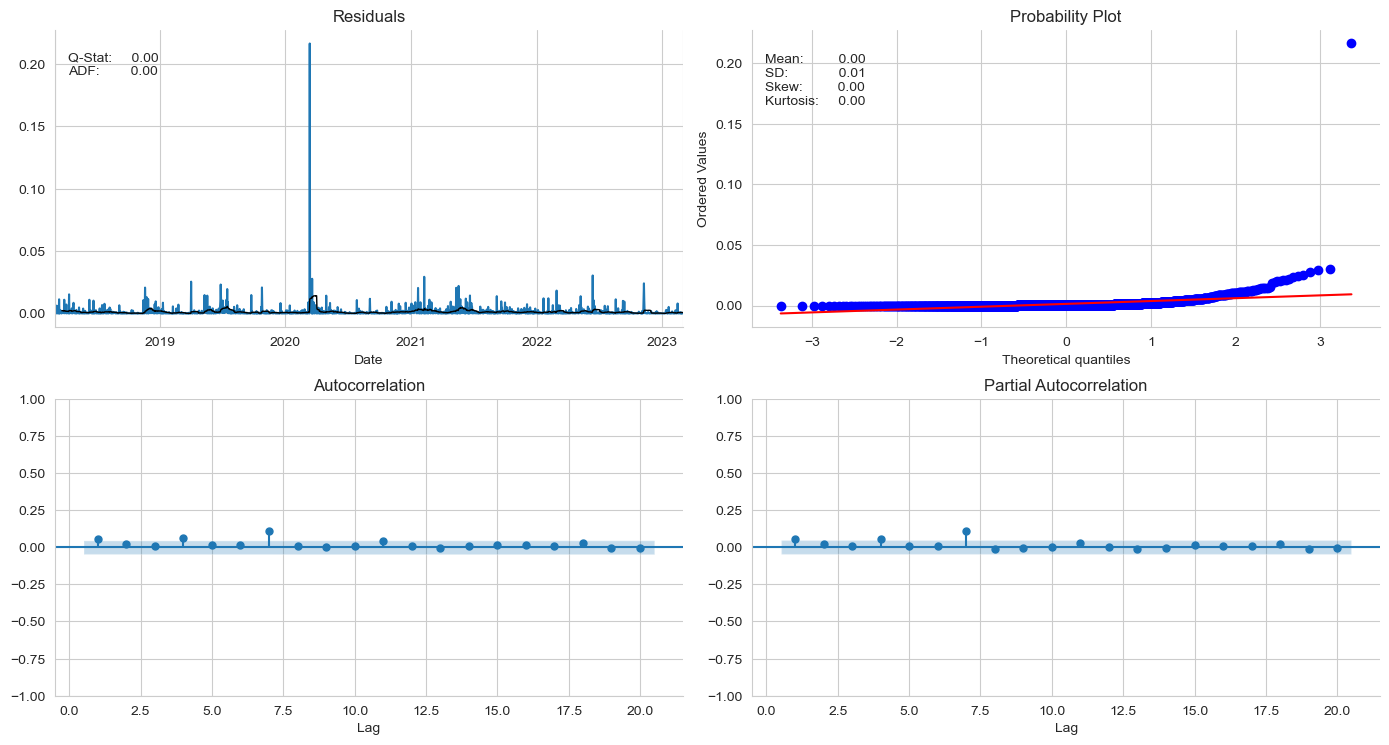

In [4]:
nvda_daily_vol = (nvda_log-nvda_log.mean())**2

plot_correlogram(x=nvda_daily_vol,
                 lags=20,
                 title=None)

In [5]:
from arch import arch_model

##### Change the number of years defends on how many years data has been used ####################
#number of year data * Working days of a year #############

trainsize = 5*365

data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

T = len(nvda_log)

results = {}

for p in range(1, 5):
    
    for q in range(1, 5):
        
        print(f'{p} | {q}')

        result = []

        for s, t in enumerate(range(trainsize, T-1)):

            train_set = data.iloc[s:t]

            test_set = data.iloc[t+1]

            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')

            forecast = model.forecast(horizon=1)

            mu = forecast.mean.iloc[-1, 0]

            var = forecast.variance.iloc[-1, 0]

            result.append([(test_set-mu)**2, var])

        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])

        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [6]:
results

{(1, 1): 0.0004835741530102727,
 (1, 2): 0.000471243610750299,
 (1, 3): 0.00044076229968016884,
 (1, 4): 0.00046731678309883416,
 (2, 1): 0.0004905821632997006,
 (2, 2): 0.0004286844519223912,
 (2, 3): 0.00044298830292376534,
 (2, 4): 0.0004788179972667616,
 (3, 1): 0.00047214448925707997,
 (3, 2): 0.0005361535590830319,
 (3, 3): 0.0004648610562612229,
 (3, 4): 0.0004757338887978888,
 (4, 1): 0.0005067763987061394,
 (4, 2): 0.0005390973620409129,
 (4, 3): 0.0004672209902642734,
 (4, 4): 0.0004719200941916812}

In [15]:
pd.DataFrame(results, index=pd.Series(0)).unstack().idxmin()

(1, 4, 0)

# Put 'p' and 'q' value below box

In [7]:
data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

best_model = arch_model(y=data, p=1, q=4).fit(update_freq=5, disp='off')

print(best_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3968.98
Distribution:                  Normal   AIC:                          -7923.96
Method:            Maximum Likelihood   BIC:                          -7885.39
                                        No. Observations:                 1827
Date:                Fri, Mar 03 2023   Df Residuals:                     1826
Time:                        10:19:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.0425e-04  6.350e-04      0.794      0.427 

# Put 'p' and 'q' value below box

In [9]:
data = nvda_log.to_frame('nvda_log_ret')

################ Here We take last 70 working days ###########################################

data['variance'] = data['nvda_log_ret'].rolling(70).var()

################ Here, Year have to change ###########################################

data = data['2022':]

def predict_volatility(x):  
    
    ######################### Confiqure the Model with above result  ##############################################
    
    best_model = arch_model(y=x, p=1, q=4).fit(update_freq=5, disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    
    print(x.index[-1])
    
    return variance_forecast

data['predictions'] = data['nvda_log_ret'].rolling(70).apply(lambda x: predict_volatility(x))

data = data.dropna()

data

2022-03-11 00:00:00+00:00


C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-03-12 00:00:00+00:00
2022-03-13 00:00:00+00:00
2022-03-14 00:00:00+00:00
2022-03-15 00:00:00+00:00
2022-03-16 00:00:00+00:00
2022-03-17 00:00:00+00:00
2022-03-18 00:00:00+00:00
2022-03-19 00:00:00+00:00
2022-03-20 00:00:00+00:00
2022-03-21 00:00:00+00:00
2022-03-22 00:00:00+00:00
2022-03-23 00:00:00+00:00
2022-03-24 00:00:00+00:00
2022-03-25 00:00:00+00:00
2022-03-26 00:00:00+00:00
2022-03-27 00:00:00+00:00
2022-03-28 00:00:00+00:00
2022-03-29 00:00:00+00:00
2022-03-30 00:00:00+00:00
2022-03-31 00:00:00+00:00
2022-04-01 00:00:00+00:00
2022-04-02 00:00:00+00:00
2022-04-03 00:00:00+00:00
2022-04-04 00:00:00+00:00
2022-04-05 00:00:00+00:00
2022-04-06 00:00:00+00:00
2022-04-07 00:00:00+00:00
2022-04-08 00:00:00+00:00
2022-04-09 00:00:00+00:00
2022-04-10 00:00:00+00:00
2022-04-11 00:00:00+00:00
2022-04-12 00:00:00+00:00
2022-04-13 00:00:00+00:00
2022-04-14 00:00:00+00:00
2022-04-15 00:00:00+00:00
2022-04-16 00:00:00+00:00
2022-04-17 00:00:00+00:00
2022-04-18 00:00:00+00:00
2022-04-19 0

C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-09-09 00:00:00+00:00
2022-09-10 00:00:00+00:00
2022-09-11 00:00:00+00:00
2022-09-12 00:00:00+00:00
2022-09-13 00:00:00+00:00
2022-09-14 00:00:00+00:00
2022-09-15 00:00:00+00:00
2022-09-16 00:00:00+00:00
2022-09-17 00:00:00+00:00
2022-09-18 00:00:00+00:00
2022-09-19 00:00:00+00:00
2022-09-20 00:00:00+00:00
2022-09-21 00:00:00+00:00
2022-09-22 00:00:00+00:00
2022-09-23 00:00:00+00:00
2022-09-24 00:00:00+00:00
2022-09-25 00:00:00+00:00
2022-09-26 00:00:00+00:00
2022-09-27 00:00:00+00:00
2022-09-28 00:00:00+00:00
2022-09-29 00:00:00+00:00
2022-09-30 00:00:00+00:00
2022-10-01 00:00:00+00:00
2022-10-02 00:00:00+00:00
2022-10-03 00:00:00+00:00
2022-10-04 00:00:00+00:00
2022-10-05 00:00:00+00:00
2022-10-06 00:00:00+00:00
2022-10-07 00:00:00+00:00
2022-10-08 00:00:00+00:00
2022-10-09 00:00:00+00:00
2022-10-10 00:00:00+00:00
2022-10-11 00:00:00+00:00
2022-10-12 00:00:00+00:00
2022-10-13 00:00:00+00:00
2022-10-14 00:00:00+00:00
2022-10-15 00:00:00+00:00
2022-10-16 00:00:00+00:00
2022-10-17 0

C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2023-01-28 00:00:00+00:00
2023-01-29 00:00:00+00:00
2023-01-30 00:00:00+00:00
2023-01-31 00:00:00+00:00
2023-02-01 00:00:00+00:00
2023-02-02 00:00:00+00:00
2023-02-03 00:00:00+00:00
2023-02-04 00:00:00+00:00
2023-02-05 00:00:00+00:00
2023-02-06 00:00:00+00:00
2023-02-07 00:00:00+00:00
2023-02-08 00:00:00+00:00
2023-02-09 00:00:00+00:00
2023-02-10 00:00:00+00:00
2023-02-11 00:00:00+00:00
2023-02-12 00:00:00+00:00
2023-02-13 00:00:00+00:00
2023-02-14 00:00:00+00:00
2023-02-15 00:00:00+00:00


C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2023-02-16 00:00:00+00:00
2023-02-17 00:00:00+00:00
2023-02-18 00:00:00+00:00
2023-02-19 00:00:00+00:00
2023-02-20 00:00:00+00:00
2023-02-21 00:00:00+00:00
2023-02-22 00:00:00+00:00
2023-02-23 00:00:00+00:00
2023-02-24 00:00:00+00:00
2023-02-25 00:00:00+00:00
2023-02-26 00:00:00+00:00


C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2023-02-27 00:00:00+00:00
2023-02-28 00:00:00+00:00
2023-03-01 00:00:00+00:00
2023-03-02 00:00:00+00:00


C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,nvda_log_ret,variance,predictions
Date,,,
2022-03-11 00:00:00+00:00,-0.016425,0.001409,0.002033
2022-03-12 00:00:00+00:00,0.002807,0.001395,0.002017
2022-03-13 00:00:00+00:00,-0.027475,0.001403,0.001958
2022-03-14 00:00:00+00:00,0.046891,0.001435,0.001995
2022-03-15 00:00:00+00:00,-0.008302,0.001434,0.001947
...,...,...,...
2023-02-26 00:00:00+00:00,0.016512,0.000533,0.000389
2023-02-27 00:00:00+00:00,-0.001629,0.000525,0.000413
2023-02-28 00:00:00+00:00,-0.016093,0.000523,0.000451


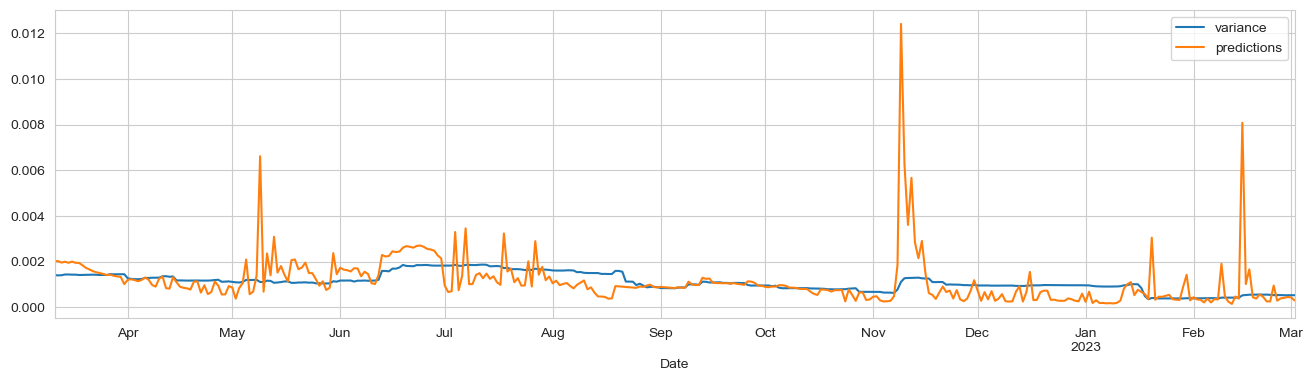

In [10]:
data[['variance', 'predictions']].plot(figsize=(16,4))

plt.show()

In [11]:
from pykalman import KalmanFilter

def KalmanFilterAverage(x):
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

data['fixed_predictions'] = KalmanFilterAverage(data['predictions'])

data

,nvda_log_ret,variance,predictions,fixed_predictions
Date,,,,
2022-03-11 00:00:00+00:00,-0.016425,0.001409,0.002033,0.001017
2022-03-12 00:00:00+00:00,0.002807,0.001395,0.002017,0.001355
2022-03-13 00:00:00+00:00,-0.027475,0.001403,0.001958,0.001510
2022-03-14 00:00:00+00:00,0.046891,0.001435,0.001995,0.001613
2022-03-15 00:00:00+00:00,-0.008302,0.001434,0.001947,0.001673
...,...,...,...,...
2023-02-26 00:00:00+00:00,0.016512,0.000533,0.000389,0.000768
2023-02-27 00:00:00+00:00,-0.001629,0.000525,0.000413,0.000735
2023-02-28 00:00:00+00:00,-0.016093,0.000523,0.000451,0.000708


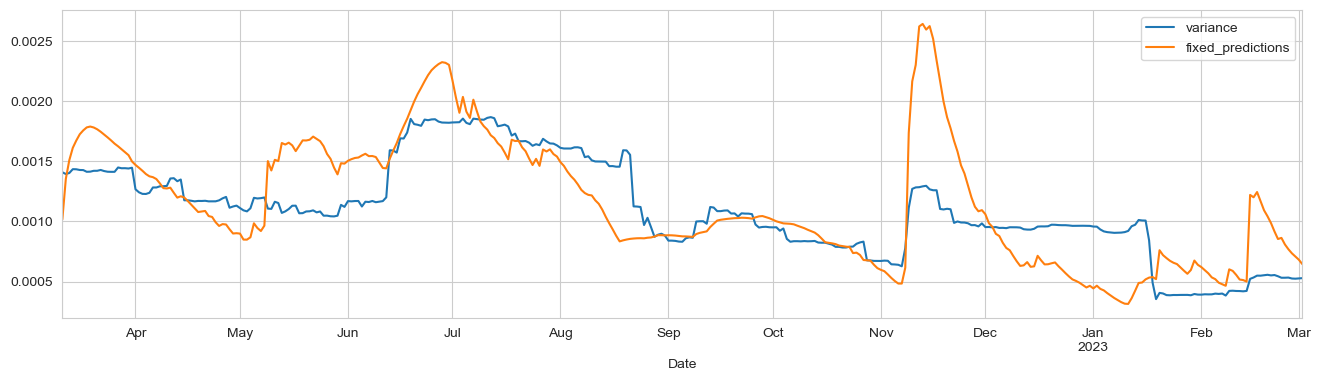

In [12]:
data[['variance', 'fixed_predictions']].plot(figsize=(16,4))

plt.show()

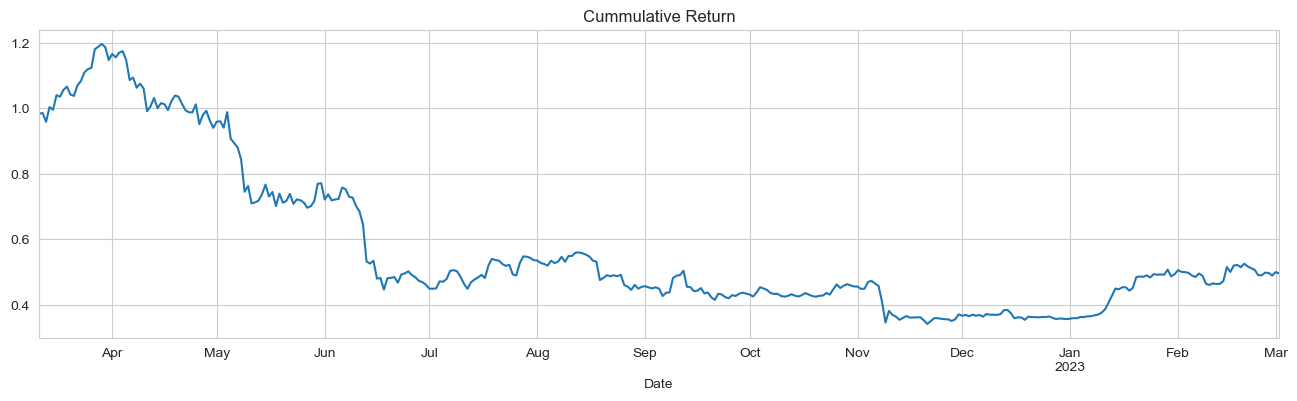

In [13]:
np.exp(np.log1p(data['nvda_log_ret']).cumsum()).plot(figsize=(16,4))

plt.title('Cummulative Return')

plt.show()

In [14]:
print(f"Sharpe Ratio : {(data['nvda_log_ret'].mean()/data['nvda_log_ret'].std())*(200**.5)}")

Sharpe Ratio : -0.6519809680523296


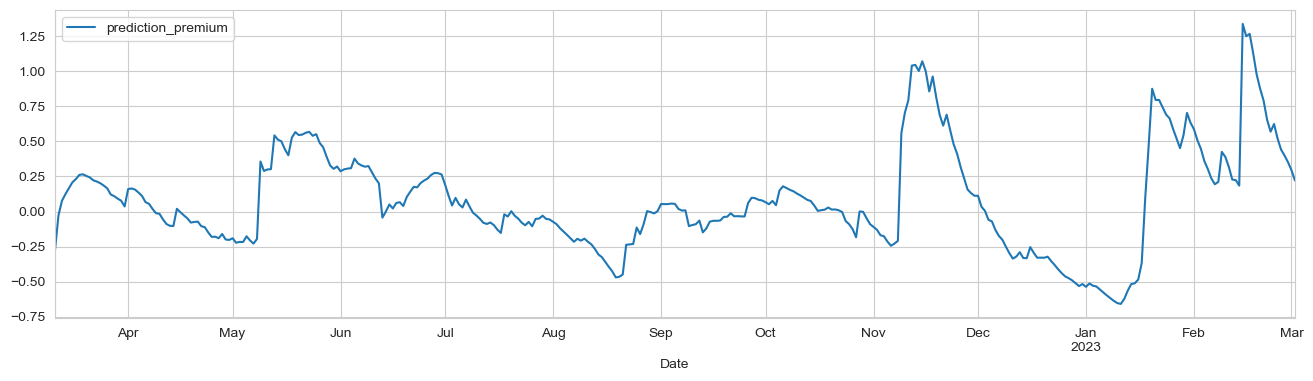

In [15]:
data['prediction_premium'] = (data['fixed_predictions']-data['variance'])/data['variance']

data[['prediction_premium']].plot(figsize=(16,4))

plt.show()

In [16]:
data['premium_diff'] = data['prediction_premium'].diff()

std = data['prediction_premium'].diff().std()

data['signal'] = data.apply(lambda x: 1 if (x['prediction_premium']<0)&(x['premium_diff']>std)
                            else (-1 if (x['prediction_premium']>0)&(x['premium_diff']<-std) else np.nan), axis=1)

data['signal'] = data['signal'].ffill(limit=5)

data['strategy_return'] = (data['nvda_log_ret']*data['signal'])

data

,nvda_log_ret,variance,predictions,fixed_predictions,prediction_premium,premium_diff,signal,strategy_return
Date,,,,,,,,
2022-03-11 00:00:00+00:00,-0.016425,0.001409,0.002033,0.001017,-0.278497,NaN,NaN,NaN
2022-03-12 00:00:00+00:00,0.002807,0.001395,0.002017,0.001355,-0.028834,0.249663,1.0,0.002807
2022-03-13 00:00:00+00:00,-0.027475,0.001403,0.001958,0.001510,0.076283,0.105118,1.0,-0.027475
2022-03-14 00:00:00+00:00,0.046891,0.001435,0.001995,0.001613,0.123801,0.047517,1.0,0.046891
2022-03-15 00:00:00+00:00,-0.008302,0.001434,0.001947,0.001673,0.166742,0.042942,1.0,-0.008302
...,...,...,...,...,...,...,...,...
2023-02-26 00:00:00+00:00,0.016512,0.000533,0.000389,0.000768,0.442425,-0.078598,-1.0,-0.016512
2023-02-27 00:00:00+00:00,-0.001629,0.000525,0.000413,0.000735,0.399588,-0.042836,-1.0,0.001629
2023-02-28 00:00:00+00:00,-0.016093,0.000523,0.000451,0.000708,0.351877,-0.047711,NaN,NaN


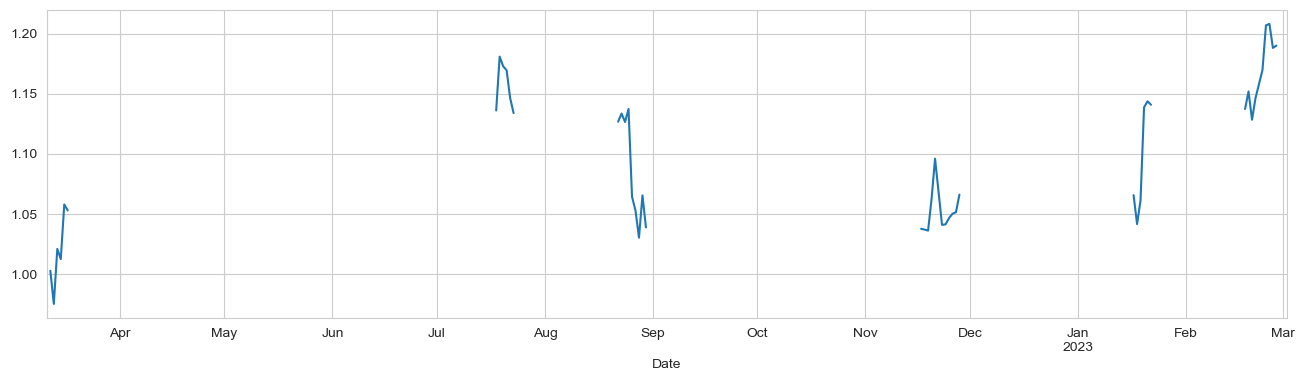

In [17]:
np.exp(np.log1p(data['strategy_return']).cumsum()).plot(figsize=(16,4))

plt.show()

In [18]:
print(f"Strategy Sharpe Ratio : {(data['strategy_return'].mean()/data['strategy_return'].std()) * (200**.5)}")

Strategy Sharpe Ratio : 2.151629264210531
